In [2]:
import pandas as pd
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import behaviour_functions as bhv
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from pylab import *
import math
import statistics
import itertools
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from pandas.api.types import CategoricalDtype
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import behaviour_functions as bhv
import statsmodels.stats 

In [3]:
# Load data
# df = pd.read_csv('/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/behaviours_df.csv')
df = pd.read_csv('/Users/irenesalgarella/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/behaviours_df.csv')


# Prepare dataset for analysis
df = df.drop(columns=['Unnamed: 0', 'duration']) # drop unnecessary columns
df['event'] = np.where(df['latency'] < 900, 1, 0) # create event column
df['time'] = df['time'].replace('baseline', 'day0') # use the replace method to change 'baseline' to 'day0'

try: 
    # extract the numeric part of the time values and convert them to integers
    df['time'] = df['time'].str.extract('(\d+)', expand=False).astype(int)
    
except:
    print('sometyhing went wrong, check that baseline has been replaced with day0')

# separate the dataframe into different timepoint groups
day_dfs = {}
for i in df.time.unique():
    day_dfs['day' + str(i)] = df[(df.time == i) & (df.behaviour == 'retrieval to nest')]


In [4]:
day_dfs['day0'].head()

,ID,time,behaviour,latency,event
4,BRAC7159.2d,0,retrieval to nest,337.974,1
108,BRAC7172.1e,0,retrieval to nest,628.090,1
220,BRAC7172.1g,0,retrieval to nest,283.766,1
332,BRAC7172.1h,0,retrieval to nest,900.000,0
444,BRAC7266.1i,0,retrieval to nest,900.000,0


In [5]:
# Run Kaplan-Meier analysis on each DataFrame in day_dfs
kmfs = {}
for key, df in day_dfs.items():
    kmf = KaplanMeierFitter()
    kmf.fit(durations = df['latency'], event_observed = df['event'], label=key)
    kmfs[key] = kmf

In [6]:
kmfs['day0']

<lifelines.KaplanMeierFitter:"day0", fitted with 10 total observations, 4 right-censored observations>

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.67 0.03      5.03
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.29 0.01      6.36
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.33 <0.005     11.13
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          15.89 <0.005     13.86
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi

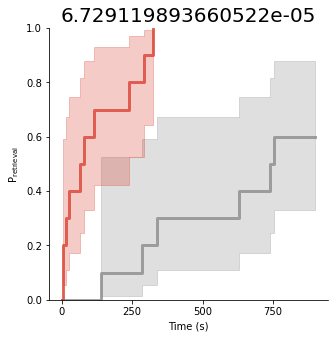

In [7]:
# Perform log-rank test on two selected DataFrames
km_results = pd.DataFrame()

for key1, df1 in day_dfs.items():
    for key2, df2 in day_dfs.items():
        if key1 != key2:
            result = logrank_test(df1['latency'], df2['latency'], 
                                  event_observed_A = df1['event'], event_observed_B=df2['event'])
            print(result)
            # Create a DataFrame for the new row and concatenate it with km_results
            new_row = pd.DataFrame({'day1': [key1], 'day2': [key2], 'p_value': [result.p_value]})
            km_results = pd.concat([km_results, new_row], ignore_index=True)
            if key1 == 'day0' and key2 == 'day4':
                # Plot the survival curves
                plt.subplots(figsize=(5,5))
                kmfs['day0'].plot_cumulative_density(ci_show=True,label=key1,
                                                    linewidth=3,color='grey',legend=False, alpha=.7)
                kmfs['day4'].plot_cumulative_density(ci_show=True,label=key2,
                                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

                plt.ylim(-0.1,1.1)
                params = {'mathtext.default': 'regular' }          
                plt.rcParams.update(params)
                plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
                plt.xlabel('Time (s)', labelpad=5)
                sns.despine()
                plt.title(str(result.p_value), fontsize=20)
                plt.locator_params(axis='x', nbins=4)
                plt.ylim(0,1)

# km_results.to_csv('/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/generated_dataset/km_results_retr-to-nest.csv')

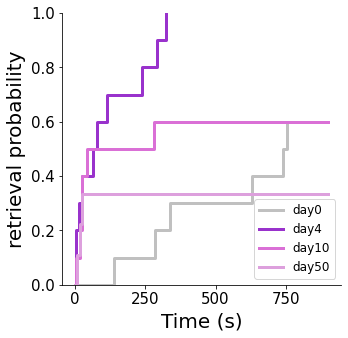

In [8]:
times = ['day0','day4', 'day10', 'day50']
col = ['silver', 'darkorchid', 'orchid', 'plum']

plt.subplots(figsize=(5,5))
for i, time in enumerate(times):
    kmfs[time].plot_cumulative_density(ci_show=False, color = col[i], linewidth=3,legend=False, alpha=1)
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel('retrieval probability', multialignment='center',labelpad=5, fontsize=20)
    plt.xlabel('Time (s)', labelpad=5, fontsize=20)
    plt.legend(labels = times, loc='lower right', fontsize=12)
    sns.despine()
    # plt.title(str(result.p_value), fontsize=20)
    plt.locator_params(axis='x', nbins=4)
    plt.ylim(0,1)

# plt.savefig(f'/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/plots_survival_curves/probability_retrieval_retr-to-nest_2.jpg', dpi = 300, bbox_inches = 'tight')
# plt.savefig(f'/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/plots_survival_curves/probability_retrieval_retr-to-nest.eps', dpi = 300, bbox_inches = 'tight')
plt.show()

(0.0, 1.0)

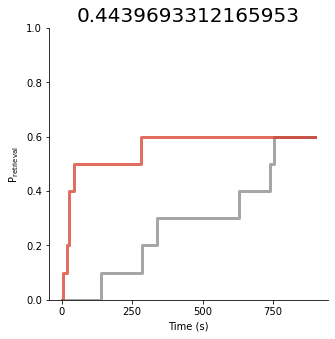

In [9]:
plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day10'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(result.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.67 0.03      5.03

0.03065679477934466
4.672079010455365


(0.0, 1.0)

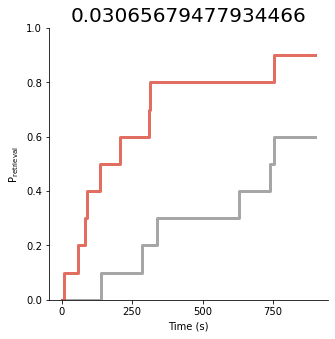

In [10]:
# Calculate log-rank test for day compared to day0

results_day1 = logrank_test(day_dfs['day0']['latency'], day_dfs['day1']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day1']['event'])

results_day1.print_summary()
print(results_day1.p_value)        
print(results_day1.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day1'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day1.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.29 0.01      6.36

0.012171480047758762
6.285717387240312


(0.0, 1.0)

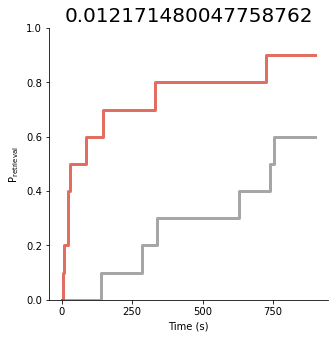

In [11]:
# Calculate log-rank test for day 2 compared to day0

results_day2 = logrank_test(day_dfs['day0']['latency'], day_dfs['day2']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day2']['event'])

results_day2.print_summary()
print(results_day2.p_value)        
print(results_day2.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day2'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day2.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.33 <0.005     11.13

0.0004453160866401883
12.3317611024021


(0.0, 1.0)

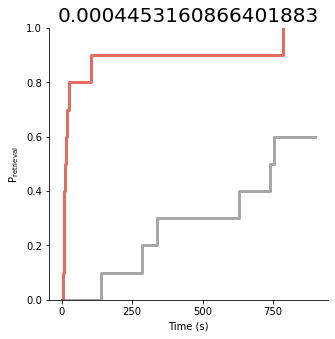

In [12]:
# Calculate log-rank test for day3 compared to day0

results_day3 = logrank_test(day_dfs['day0']['latency'], day_dfs['day3']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day3']['event'])

results_day3.print_summary()
print(results_day3.p_value)        
print(results_day3.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day3'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day3.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          15.89 <0.005     13.86

6.729119893660522e-05
15.885531045053389


(0.0, 1.0)

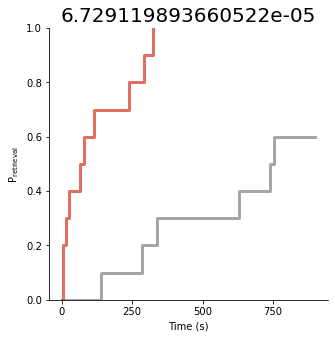

In [13]:
# Calculate log-rank test for day 4 compared to day0

results_day4 = logrank_test(day_dfs['day0']['latency'], day_dfs['day4']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day4']['event'])

results_day4.print_summary()
print(results_day4.p_value)        
print(results_day4.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day4'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day4.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.25 <0.005     14.14

5.557667122043828e-05
16.247711939574156


(0.0, 1.0)

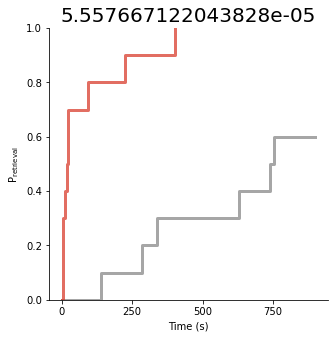

In [14]:
# Calculate log-rank test for day 5 compared to day0

results_day5 = logrank_test(day_dfs['day0']['latency'], day_dfs['day5']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day5']['event'])

results_day5.print_summary()
print(results_day5.p_value)        
print(results_day5.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day5'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day5.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.26 <0.005     15.66

1.9294278502354935e-05
18.257716044042407


(0.0, 1.0)

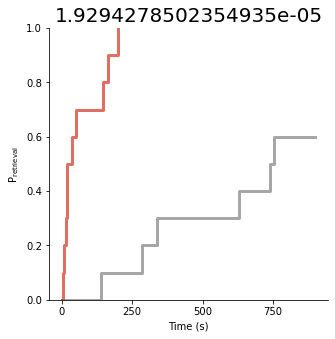

In [15]:
# Calculate log-rank test for day 6 compared to day0

results_day6 = logrank_test(day_dfs['day0']['latency'], day_dfs['day6']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day6']['event'])

results_day6.print_summary()
print(results_day6.p_value)        
print(results_day6.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day6'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day6.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.56 0.46      1.14

0.4553224175202253
0.5573686080831537


(0.0, 1.0)

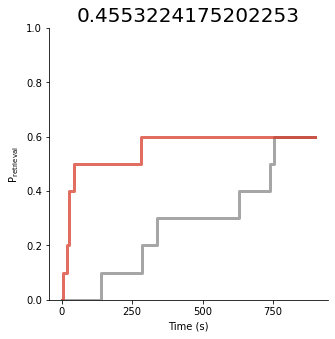

In [16]:
# Calculate log-rank test for day 10 compared to day0

results_day10 = logrank_test(day_dfs['day0']['latency'], day_dfs['day10']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day10']['event'])

results_day10.print_summary()
print(results_day10.p_value)        
print(results_day10.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day10'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day10.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.56 0.46      1.14

0.4553224175202253
0.5573686080831537


(0.0, 1.0)

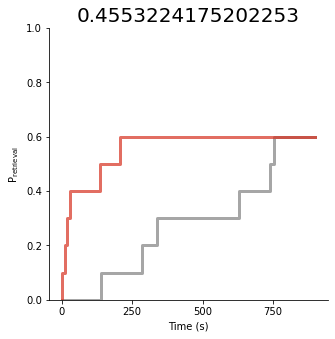

In [17]:
# Calculate log-rank test for day 14 compared to day0

results_day14 = logrank_test(day_dfs['day0']['latency'], day_dfs['day14']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day14']['event'])

results_day14.print_summary()
print(results_day14.p_value)        
print(results_day14.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day14'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day14.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.94 0.05      4.40

0.04722210541401046
3.9374572040125613


(0.0, 1.0)

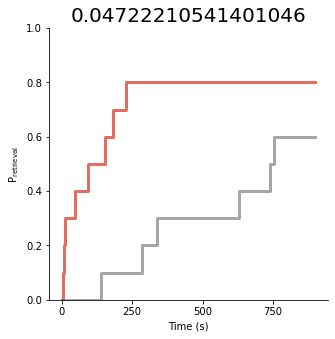

In [18]:
# Calculate log-rank test for day 18 compared to day0

results_day18 = logrank_test(day_dfs['day0']['latency'], day_dfs['day18']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day18']['event'])

results_day18.print_summary()
print(results_day18.p_value)        
print(results_day18.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day18'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day18.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.89      0.17

0.8886237709964409
0.01961283771407967


(0.0, 1.0)

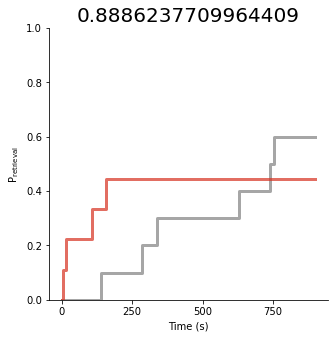

In [19]:
# Calculate log-rank test for day 22 compared to day0

results_day22 = logrank_test(day_dfs['day0']['latency'], day_dfs['day22']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day22']['event'])

results_day22.print_summary()
print(results_day22.p_value)        
print(results_day22.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day22'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day22.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.16 0.69      0.54

0.6874134285676939
0.16189977580908055


(0.0, 1.0)

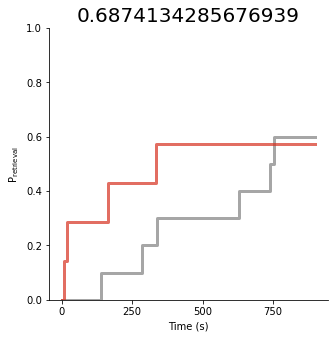

In [20]:
# Calculate log-rank test for day 26 compared to day0

results_day26 = logrank_test(day_dfs['day0']['latency'], day_dfs['day26']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day26']['event'])

results_day26.print_summary()
print(results_day26.p_value)        
print(results_day26.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day26'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day26.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.49 0.48      1.05

0.4834192696342551
0.49113988143199644


(0.0, 1.0)

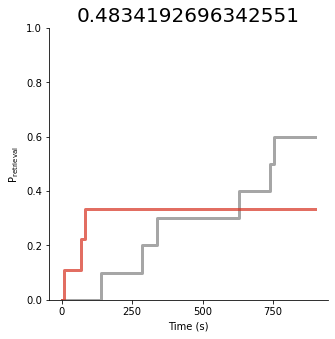

In [21]:
# Calculate log-rank test for day 30 compared to day0

results_day30 = logrank_test(day_dfs['day0']['latency'], day_dfs['day30']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day30']['event'])

results_day30.print_summary()
print(results_day30.p_value)        
print(results_day30.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day30'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day30.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.49 0.48      1.05

0.4834192696342551
0.49113988143199644


(0.0, 1.0)

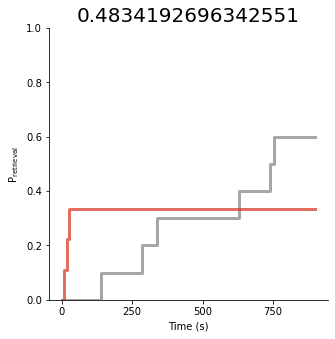

In [22]:
# Calculate log-rank test for day 50 compared to day0

results_day50 = logrank_test(day_dfs['day0']['latency'], day_dfs['day50']['latency'], 
                        event_observed_A = day_dfs['day0']['event'], event_observed_B=day_dfs['day50']['event'])

results_day50.print_summary()
print(results_day50.p_value)        
print(results_day50.test_statistic)

plt.subplots(figsize=(5,5))
kmfs['day0'].plot_cumulative_density(ci_show=False,label=key1,
                                    linewidth=3,color='grey',legend=False, alpha=.7)
kmfs['day50'].plot_cumulative_density(ci_show=False,label=key2,
                                    linewidth=3,color='#d7301f',legend=False, alpha=.7)

plt.ylim(-0.1,1.1)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.ylabel('$P_{retrieval}$', multialignment='center',labelpad=5)
plt.xlabel('Time (s)', labelpad=5)
sns.despine()
plt.title(str(results_day50.p_value), fontsize=20)
plt.locator_params(axis='x', nbins=4)
plt.ylim(0,1)

In [23]:
# correct for multiple comparisons; Benjamini-Hochberg false discovery rate

p_values = np.array([results_day1.p_value, results_day2.p_value, results_day3.p_value, results_day4.p_value, results_day5.p_value, results_day6.p_value, 
                     results_day10.p_value, results_day14.p_value, results_day18.p_value, results_day22.p_value, 
                     results_day26.p_value, results_day30.p_value, results_day50.p_value])

results = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh',returnsorted=False)
print(results)

(array([False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False]), array([6.64230554e-02, 3.16458481e-02, 1.44727728e-03, 2.91595195e-04,
       2.91595195e-04, 2.50825621e-04, 5.71313682e-01, 5.71313682e-01,
       8.76981958e-02, 8.88623771e-01, 7.44697881e-01, 5.71313682e-01,
       5.71313682e-01]), 0.0039378642276444165, 0.0038461538461538464)


In [24]:
comparisons = ['day0_day1', 'day0_day2', 'day0_day3', 'day0_day4', 'day0_day5', 'day0_day6', 
               'day0_day10', 'day0_day14', 'day0_day18', 'day0_day22', 
               'day0_day26', 'day0_day30', 'day0_day50']

across_groups = pd.DataFrame(results[1], columns=['corrected p values'])
across_groups['non-corrected p value'] = p_values
across_groups['comparison'] = comparisons

sign = []
for x in results[1]:
    if x > 0.05:
        sign.append('ns')
    elif x <= 0.05 and x > 0.01:
        sign.append('*')
    elif x <= 0.01 and x > 0.001:
        sign.append('**')
    elif x <= 0.001 and x > 0.0001:
        sign.append('***')
    else:
        sign.append('****')

across_groups['(*)'] = sign    

across_groups

,corrected p values,non-corrected p value,comparison,(*)
0,0.066423,0.030657,day0_day1,ns
1,0.031646,0.012171,day0_day2,*
2,0.001447,0.000445,day0_day3,**
3,0.000292,0.000067,day0_day4,***
4,0.000292,0.000056,day0_day5,***
5,0.000251,0.000019,day0_day6,***
6,0.571314,0.455322,day0_day10,ns
7,0.571314,0.455322,day0_day14,ns
8,0.087698,0.047222,day0_day18,ns
9,0.888624,0.888624,day0_day22,ns
